## Preprocessing

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.interfaces.utility as util 
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import Function, IdentityInterface
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype.interfaces.base import Bunch
from nipype import DataGrabber, Workflow, Node
from scipy.io.matlab import loadmat

In [2]:
# necessary to let nipype know about matlab path

In [3]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [4]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [5]:
# spm.SPMCommand().version

In [6]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [7]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [8]:
experiment_dir = os.path.join(base_dir, 'output')
data_dir = os.path.abspath(os.path.join(base_dir, 'face_rep'))
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['M03953']

# TR of functional images
TR = 2.


# Smoothing width used during preprocessing
fwhm = [8]

In [9]:
# add how to refer sots

In [10]:
#mat0 = mat = loadmat(os.path.join(data_dir, "sots.mat"), mat_dtype=True, matlab_compatible=True, struct_as_record=True)

In [11]:
mat = loadmat(os.path.join(data_dir, "sots.mat"), mat_dtype=True, matlab_compatible=True, struct_as_record=True, simplify_cells=True)
#sot = mat['sot'][1]

#itemlag = mat['itemlag'][0]
#onsets=[sot[0], sot[1], sot[2], sot[3]],
itemlag = mat['itemlag']

In [23]:
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Wed Jun  4 11:58:02 2008', '__version__': '1.0', '__globals__': [], 'itemlag': array([array([], dtype=float64),
       array([ 3.,  3., 10., 10., 14.,  1., 23.,  3.,  3., 37., 10., 42., 61.,
              33., 27., 61., 28., 22., 39., 37., 62., 37., 20., 54., 34., 50.]),
       array([], dtype=float64),
       array([11., 14.,  2., 47., 36., 18., 37., 59., 11., 56., 33.,  4., 57.,
              18., 59., 55., 46., 61.,  4., 67.,  9., 63., 13., 19., 42.,  1.])],
      dtype=object), 'sot': array([array([  6.74996667,  15.74996667,  17.99996667,  26.99996667,
               29.24996667,  31.49996667,  35.99996667,  42.74996667,
               65.24996667,  67.49996667,  74.24996667,  92.24996667,
              112.49996667, 119.24996667, 123.74996667, 125.99996667,
              137.24996667, 141.74996667, 143.99996667, 146.24996667,
              155.24996667, 159.74996667, 161.99996667, 164.24996667,
              204.

In [24]:
param1 = mat['itemlag'][1],

In [29]:
itemlag = mat['itemlag']

In [30]:
print(itemlag)

[array([], dtype=float64)
 array([ 3.,  3., 10., 10., 14.,  1., 23.,  3.,  3., 37., 10., 42., 61.,
        33., 27., 61., 28., 22., 39., 37., 62., 37., 20., 54., 34., 50.])
 array([], dtype=float64)
 array([11., 14.,  2., 47., 36., 18., 37., 59., 11., 56., 33.,  4., 57.,
        18., 59., 55., 46., 61.,  4., 67.,  9., 63., 13., 19., 42.,  1.])]


In [31]:
itemlag[1]

array([ 3.,  3., 10., 10., 14.,  1., 23.,  3.,  3., 37., 10., 42., 61.,
       33., 27., 61., 28., 22., 39., 37., 62., 37., 20., 54., 34., 50.])

In [25]:
print(param1)

(array([ 3.,  3., 10., 10., 14.,  1., 23.,  3.,  3., 37., 10., 42., 61.,
       33., 27., 61., 28., 22., 39., 37., 62., 37., 20., 54., 34., 50.]),)


In [12]:
itemlag = mat['itemlag'][1]

In [13]:
f = mat['itemlag'][3].tolist()

In [17]:
print(len(f))

26


In [15]:
print(itemlag.size)

26


In [12]:
subjectinfo = [
    Bunch(
        conditions=['N1', 'N2', 'F1', 'F2'],
        onsets=[ mat['sot'][0], mat['sot'][1],  mat['sot'][2],  mat['sot'][3]],
        durations=[[0], [0], [0], [0]],
        amplitudes=None,
        tmod=None,
        pmod=None,
        regressor_names=None,
        regressors=None)
]

In [12]:
subjectinfo_param = [
    Bunch(
        conditions=['N1', 'N2', 'F1', 'F2'],
        onsets=[mat['sot'][0], mat['sot'][1],  mat['sot'][2],  mat['sot'][3]],
        durations=[[0], [0], [0], [0]],
        amplitudes=None,
        tmod=0,
        pmod=[
            None,
            Bunch(name=['Lag'], param=itemlag[1], poly=[2]), 
            None,
            Bunch(name=['Lag'], param=itemlag[3], poly=[2])
        ],
        regressor_names=None,
        regressors=None)
]

In [26]:
subjectinfo_param = [
        [conditions=['N1', 'N2', 'F1', 'F2']],
        [onsets=[mat['sot'][0], mat['sot'][1],  mat['sot'][2],  mat['sot'][3]]],
        [durations=[[0], [0], [0], [0]]],
        amplitudes=None,
        tmod=0,
        pmod=[
            None,
            Bunch(name=['Lag'], param=itemlag[1], poly=[2]), 
            None,
            Bunch(name=['Lag'], param=itemlag[3], poly=[2])
        ],
        regressor_names=None,
        regressors=None
]

SyntaxError: invalid syntax (3944740332.py, line 2)

In [13]:
cont1 = ('Famous_lag1', 'T', ['F2xLag^1'], [1])
cont2 = ('Famous_lag2', 'T', ['F2xLag^2'], [1])
fcont1 = ('Famous Lag', 'F', [cont1, cont2])
paramcontrasts = [cont1, cont2, fcont1]

In [ ]:
paramanalysis = l1analysis.clone(name='paramanalysis')

paramanalysis.inputs.level1design.bases = {'hrf': {'derivs': [0, 0]}}
paramanalysis.inputs.modelspec.subject_info = subjectinfo_param
paramanalysis.inputs.contrastestimate.contrasts = paramcontrasts
paramanalysis.inputs.contrastestimate.use_derivs = False


In [ ]:
l1pipeline.connect(
    [(preproc, paramanalysis,
      [('realign.realignment_parameters', 'modelspec.realignment_parameters'),
       (('smooth.smoothed_files', makelist), 'modelspec.functional_runs')])

In [13]:
# design matrix setting

In [14]:
# SpecifyModel - Generates SPM-specific Model
specmodel = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='scans',
                                 output_units='scans',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128,
                                 subject_info = subjectinfo_param),
                 name="specmodel")

# Level1Design - Generates an SPM design matrix same as the first level tutorial
eventparam = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='scans',
                                 interscan_interval=TR,
                                 volterra_expansion_order=1, # no model interction
                                 flags={'mthresh': 0.8},
                                 global_intensity_normalization='none',
                                 microtime_onset=12,
                                 microtime_resolution=24,
                                 factor_info = [dict(name = 'Fame', levels = 2), # figure out factorized output names
                                                dict(name = 'Rep', levels = 2)],
                                 model_serial_correlations='AR(1)'), #matlabbatch{1}.spm.stats.fmri_spec.cvi = 'AR(1)';
                    name="eventparam")

# EstimateModel - estimate the parameters of the model
paramestimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      write_residuals=False, 
                      name="paramestimate")

# EstimateContrast - estimates contrasts
paramconest = Node(EstimateContrast(contrasts = paramcontrasts),
                    use_derivs=False, 
                    name="paramconest")

In [15]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=paramcontrasts),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]


templates = {'func': os.path.join(output_dir, 'preproc', '_subject_id_{subject_id}',
                         's{subject_id}_0005_0006_merged.nii'),
             'mc_param': os.path.join(output_dir, 'preproc', '_subject_id_{subject_id}',
                         'rp_s{subject_id}_0005_0006_merged.txt'),
             'outliers': os.path.join(output_dir, 'preproc', '_subject_id_{subject_id}', 
                             'art.wars{subject_id}_0005_0006_merged_outliers.txt'),
             'smooths': os.path.join(output_dir, 'preproc', '_subject_id_{subject_id}',
                         'swars{subject_id}_0005_0006_merged.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [16]:
# Initiation of the 1st-level analysis workflow
event_param = Workflow(name='event_param')
event_param.base_dir = os.path.join(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
event_param.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, paramconest, [('contrasts', 'contrasts')]),
                    (selectfiles, specmodel, [('smooths', 'functional_runs')]),
                    (selectfiles, specmodel, [('mc_param', 'realignment_parameters'),
                                                ('outliers', 'outlier_files')]),
                    (specmodel, eventparam, [('session_info','session_info')]),
                    (eventparam, paramestimate, [('spm_mat_file','spm_mat_file')]),                    
                    (paramestimate, paramconest, [('spm_mat_file','spm_mat_file'),
                                                    ('beta_images','beta_images'),
                                                   ('residual_image', 'residual_image')]),
                    (paramconest, datasink, [('spm_mat_file', 'event_param.@spm_mat'),
                                              ('spmT_images', 'event_param.@T'),
                                              ('con_images', 'event_param.@con'),
                                              ('spmF_images', 'event_param.@F'),
                                              ('ess_images', 'event_param.@ess')]),
                    ])

In [17]:
event_param.write_graph(graph2use='colored', format='png', dotfilename='colored_graph.dot', simple_form=True)

240523-09:12:49,490 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_param/colored_graph.png (graph2use=colored, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_param/colored_graph.png'

In [18]:
event_param.write_graph(graph2use='flat', format='png', dotfilename='flat_graph.dot', simple_form=True)

240523-09:12:52,397 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_param/flat_graph.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_param/flat_graph.png'

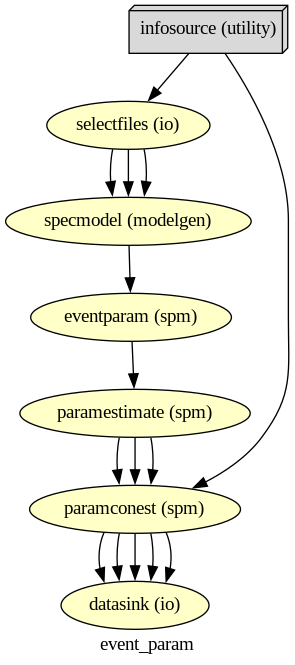

In [20]:
# Visualize the graph
from IPython.display import Image
Image(filename='./spmbasics/data/output/workingdir/event_param/colored_graph.png')

In [21]:
event_param.run('MultiProc', plugin_args={'n_procs': 4})

240523-09:13:22,627 nipype.workflow INFO:
	 Workflow event_param settings: ['check', 'execution', 'logging', 'monitoring']
240523-09:13:22,633 nipype.workflow INFO:
	 Running in parallel.
240523-09:13:22,634 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240523-09:13:22,702 nipype.workflow INFO:
	 [Node] Setting-up "event_param.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/event_param/_subject_id_M03953/selectfiles".
240523-09:13:22,706 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240523-09:13:22,708 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.000831s.
240523-09:13:24,639 nipype.workflow INFO:
	 [Job 0] Completed (event_param.selectfiles).
240523-09:13:24,645 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240523-09:13:24,717 nipype.workflow INFO:
	 

stty: 'standard input': Inappropriate ioctl for device


240523-09:13:43,721 nipype.workflow INFO:
	 [Node] Finished "eventparam", elapsed time 9.625525s.
240523-09:13:43,723 nipype.workflow WARNING:
	 Storing result file without outputs
240523-09:13:43,727 nipype.workflow WARNING:
	 [Node] Error on "event_param.eventparam" (/home/matay/spmbasics/data/output/workingdir/event_param/_subject_id_M03953/eventparam)


stty: 'standard input': Inappropriate ioctl for device


240523-09:13:44,662 nipype.workflow ERROR:
	 Node eventparam.a0 failed to run on host ptb-03240070.irisa.fr.
240523-09:13:44,664 nipype.workflow ERROR:
	 Saving crash info to /home/matay/spmbasics/src/Nipype/Notebooks/crash-20240523-091344-matay-eventparam.a0-01af0d5d-3682-4a7d-bd1f-93ac00f26dfa.pklz
Traceback (most recent call last):
  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_comman

RuntimeError: Traceback (most recent call last):
  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/pipeline/plugins/multiproc.py", line 67, in run_node
    result["result"] = node.run(updatehash=updatehash)
  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)
nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node eventparam.

Traceback:
	Traceback (most recent call last):
	  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 397, in run
	    runtime = self._run_interface(runtime)
	  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/interfaces/spm/base.py", line 386, in _run_interface
	    results = self.mlab.run()
	  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 397, in run
	    runtime = self._run_interface(runtime)
	  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/interfaces/matlab.py", line 164, in _run_interface
	    self.raise_exception(runtime)
	  File "/home/matay/anaconda3/envs/spmbasics/lib/python3.9/site-packages/nipype/interfaces/base/core.py", line 685, in raise_exception
	    raise RuntimeError(
	RuntimeError: Command:
	/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash -nodesktop -nosplash -singleCompThread -r "addpath('/home/matay/spmbasics/data/output/workingdir/event_param/_subject_id_M03953/eventparam');pyscript_level1design;exit"
	Standard output:

	                                                                              < M A T L A B (R) >
	                                                                    Copyright 1984-2020 The MathWorks, Inc.
	                                                                R2020b Update 1 (9.9.0.1495850) 64-bit (glnxa64)
	                                                                               September 30, 2020

 
	To get started, type doc.
	For product information, visit www.mathworks.com.
 
	Executing pyscript_level1design at 23-May-2024 09:13:37:
	Executing pyscript_level1design at 23-May-2024 09:13:37:
	---------------------------------------------------------------------------------------------------------
	MATLAB Version: 9.9.0.1495850 (R2020b) Update 1
	MATLAB License Number: 2473
	Operating System: Linux 6.8.10-200.fc39.x86_64 #1 SMP PREEMPT_DYNAMIC Fri May 17 21:20:15 UTC 2024 x86_64
	Java Version: Java 1.8.0_202-b08 with Oracle Corporation Java HotSpot(TM) 64-Bit Server VM mixed mode
	---------------------------------------------------------------------------------------------------------
	MATLAB                                                Version 9.9         (R2020b)
	Simulink                                              Version 10.2        (R2020b)
	Bioinformatics Toolbox                                Version 4.15        (R2020b)
	Communications Toolbox                                Version 7.4         (R2020b)
	Computer Vision Toolbox                               Version 9.3         (R2020b)
	Control System Toolbox                                Version 10.9        (R2020b)
	DSP System Toolbox                                    Version 9.11        (R2020b)
	Deep Learning Toolbox                                 Version 14.1        (R2020b)
	Fixed-Point Designer                                  Version 7.1         (R2020b)
	HDL Coder                                             Version 3.17        (R2020b)
	Image Acquisition Toolbox                             Version 6.3         (R2020b)
	Image Processing Toolbox                              Version 11.2        (R2020b)
	MATLAB Coder                                          Version 5.1         (R2020b)
	MATLAB Compiler                                       Version 8.1         (R2020b)
	MATLAB Compiler SDK                                   Version 6.9         (R2020b)
	Navigation Toolbox                                    Version 1.2         (R2020b)
	Optimization Toolbox                                  Version 9.0         (R2020b)
	Parallel Computing Toolbox                            Version 7.3         (R2020b)
	Partial Differential Equation Toolbox                 Version 3.5         (R2020b)
	ROS Toolbox                                           Version 1.2         (R2020b)
	Robotics System Toolbox                               Version 3.2         (R2020b)
	Robust Control Toolbox                                Version 6.9         (R2020b)
	Signal Processing Toolbox                             Version 8.5         (R2020b)
	SimBiology                                            Version 6.0         (R2020b)
	Simscape                                              Version 5.0         (R2020b)
	Simscape Multibody                                    Version 7.2         (R2020b)
	Simulink 3D Animation                                 Version 9.1         (R2020b)
	Simulink Coder                                        Version 9.4         (R2020b)
	Simulink Control Design                               Version 5.6         (R2020b)
	Stateflow                                             Version 10.3        (R2020b)
	Statistics and Machine Learning Toolbox               Version 12.0        (R2020b)
	Symbolic Math Toolbox                                 Version 8.6         (R2020b)
	System Identification Toolbox                         Version 9.13        (R2020b)
	SPM version: SPM12 Release: 7771
	SPM path: /home/matay/Documents/MATLAB/spm12/spm.m
	Can not initialise pmod value(s): job is not a struct.
	Can not initialise pmod value(s): job is not a struct.


	------------------------------------------------------------------------
	23-May-2024 09:13:41 - Running job #1
	------------------------------------------------------------------------
	Contents of 'cond' does not meet check criteria:
	'"N2" & "Lag":Number of event onsets (26) does not equal the number of parameters (1).
	'
	Contents of 'cond' does not meet check criteria:
	'"F2" & "Lag":Number of event onsets (26) does not equal the number of parameters (1).
	'
	No executable modules, but still unresolved dependencies or incomplete module inputs.
	The following modules did not run:
	Skipped: fMRI model specification

	Standard error:
	MESA-LOADER: failed to open iris: /soft/matlab_hd/R2020b/bin/glnxa64/../../sys/os/glnxa64/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by /usr/lib64/dri/iris_dri.so) (search paths /usr/lib64/dri, suffix _dri)
	failed to load driver: iris
	MESA-LOADER: failed to open swrast: /soft/matlab_hd/R2020b/bin/glnxa64/../../sys/os/glnxa64/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by /usr/lib64/dri/swrast_dri.so) (search paths /usr/lib64/dri, suffix _dri)
	failed to load driver: swrast
	MATLAB code threw an exception:
	Job execution failed. The full log of this run can be found in MATLAB command window, starting with the lines (look for the line showing the exact #job as displayed in this error message)
	------------------ 
	Running job #1
	------------------

	File:
	Name:MATLABbatch system
	Line:0
	Return code: 0

